In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import csv
import openpyxl
from itertools import islice

import geojson
from shapely.geometry import Polygon, LineString
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon

# Compute density (cell / mm3 )

## Convert QuPath Cell detection data to pandas
#### 404_cell_position.txt are created thanks to QuPath script: export-annotation_geojson.groovy

In [2]:
input_file = '../Results/404_1_cell_position.txt'
wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 

In [3]:
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)

In [4]:
df_404

,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Detection probability,Area µm^2,Length µm,Circularity,...,Hematoxylin: Mean,Hematoxylin: Median,Hematoxylin: Min,Hematoxylin: Max,Hematoxylin: Std.Dev.,DAB: Mean,DAB: Median,DAB: Min,DAB: Max,DAB: Std.Dev.
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10994.1,1579.9,0.9553,204.0999,51.3083,0.9743,...,0.4352,0.4596,0.0985,0.6285,0.1088,-0.0564,-0.065,-0.1214,0.0345,0.0307
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10338.3,1086.9,0.9483,141.9265,42.9522,0.9667,...,0.3894,0.3993,0.0851,0.7853,0.1471,-0.0271,-0.0311,-0.0993,0.0558,0.0345
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10910,1918.6,0.9421,78.139,31.9661,0.9609,...,0.3618,0.4018,0.1157,0.5214,0.1028,-0.0338,-0.0439,-0.0819,0.0481,0.0311
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10814.4,1857.8,0.9394,106.109,36.9105,0.9787,...,0.3775,0.4081,0.0821,0.5759,0.1284,-0.0219,-0.0319,-0.077,0.0661,0.035
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10864.3,860.66,0.9386,150.2629,44.0608,0.9727,...,0.3957,0.4206,0.1099,0.6633,0.1043,-0.047,-0.0589,-0.1084,0.0572,0.0359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10156,1380.9,0.4702,29.2688,19.9869,0.9207,...,0.4403,0.4262,0.2824,0.6486,0.1003,-0.0518,-0.0514,-0.0971,-0.0153,0.0195
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,11446.9,1269.3,0.4702,20.3005,19.4503,0.6743,...,0.3809,0.3806,0.2474,0.6075,0.0756,-0.0391,-0.0442,-0.0832,0.0154,0.0245
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10433.2,2023.4,0.47,23.5266,21.2471,0.6549,...,0.5055,0.4886,0.3132,0.7993,0.106,-0.0701,-0.067,-0.1213,-0.0357,0.0233
SLD_0000404.vsi - 20x_01,PathDetectionObject,,S1,Polygon,10584.6,890.43,0.47,31.5718,28.3127,0.4949,...,0.4108,0.4176,0.2208,0.6116,0.1034,-0.0454,-0.0477,-0.077,0.0031,0.0165


In [5]:
cells_centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
cells_centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

## Convert QuPath S1 annotation to polygon 
### S1 data are create thanks to Quath script 

In [6]:
'''
with open('/tmp/pixel_size.txt', 'r') as f:
    pixel_size = float(f.readline())
print("pixel size:", pixel_size)
'''
pixel_size = 0.3460130331522824

In [7]:
s1_geo = geojson.load(open('../Results/S1.geojson','rb'))
s1_coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0]) * pixel_size

##  analyse

In [8]:
s1_button=s1_coordinates[:,1].min()
s1_top=s1_coordinates[:,1].max()
print('button {}, top {}'.format(s1_button, s1_top))
z_length = 50 / 1e3 # mm
nb_slice = 100

button 255.3576184663844, top 2615.858530631255


## Plot cell positions 

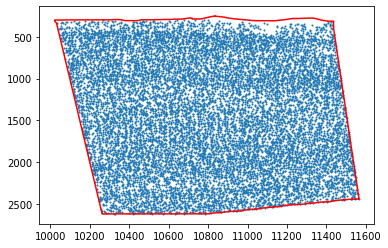

In [30]:
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
_ = plt.scatter(cells_centroid_x, cells_centroid_y, s=1)

In [11]:
#nb_points_per_bin = fract_hist[0]

# Create lines to split S1

In [12]:
slice_y_length = s1_length / nb_slice
split_lines_y_coord = np.arange(s1_button + slice_y_length, s1_top, slice_y_length)

s1_x_min = 0.#s1_coordinates[:,0].min()
s1_x_max = 15000# s1_coordinates[:,0].max()
split_lines = []
for split_line_y_coord in split_lines_y_coord:
    split_lines.append(LineString([[s1_x_min-1, split_line_y_coord], [s1_x_max+1, split_line_y_coord]]))

# split S1 polygon in layers

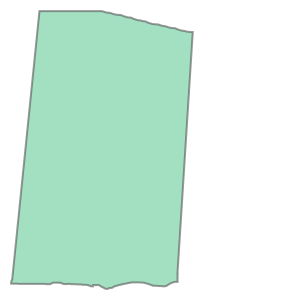

In [13]:
s1_polygon = Polygon(s1_coordinates)
s1_polygon

In [14]:
split_polygons = []
polygon_to_split = s1_polygon
for line in split_lines: 
    split_result = split(polygon_to_split, line)
    split_polygons.append(split_result[0])
    polygon_to_split = split_result[1]
    
split_polygons.append(polygon_to_split)

# Compute nb cell per slide

In [21]:
nb_points_per_bin = np.zeros(len(split_polygons), dtype=int)
for index, polygon in enumerate(split_polygons):
    nb_points_per_bin[index] = np.where((cells_centroid_y >= polygon.bounds[1]) & (cells_centroid_y < polygon.bounds[3]))[0].shape[0]

# Verify slices area

In [22]:
split_polygon_areas = [(polygon.area / 1e6) for polygon in split_polygons]
total_area = sum(split_polygon_areas)
print('Recomputed area {:.2f} %'.format((total_area / (s1_polygon.area / 1e6)) * 100))


Recomputed area 99.84 %


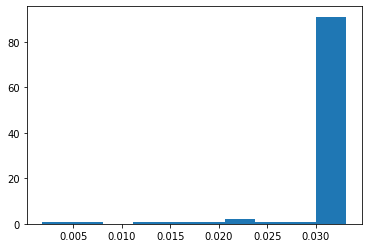

In [23]:
_= plt.hist(split_polygon_areas) # square millimeter mm2

# Compute densities from fractions and volume

In [24]:
densities = nb_points_per_bin / (np.array(split_polygon_areas) * z_length)

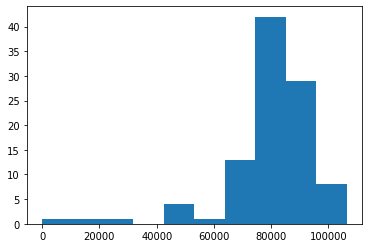

In [25]:
_ = plt.hist(densities) # nb_cell by cubic millimeter mm3

In [26]:
nb_cell = cells_centroid_x.shape[0]
total_volume = s1_polygon.area / 1e6 * z_length
print('Total density cell/mm3=', nb_cell / total_volume)

Total density cell/mm3= 81020.42026784115


Text(0, 0.5, 'Cell density (cells/mm3)')

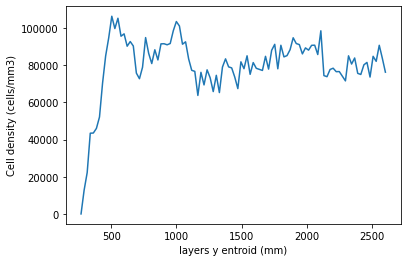

In [27]:
start = s1_button +  slice_y_length / 2
step = slice_y_length
layers_y_centroid = np.arange(start, s1_top, step)
plt.plot(layers_y_centroid, densities)
plt.xlabel("layers y entroid (mm)")
plt.ylabel("Cell density (cells/mm3)")